In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')

In [3]:
Participants = pd.read_csv('participants.csv',index_col='id')
Questions = pd.read_csv('questions.csv',index_col='id')

In [143]:
# Participants table structure
Participants.head(2)

,start_time,target_color,completed,proposal_sd,from_mturk,mturk_code
id,,,,,,
67,2015-05-03 04:42:34.077833+00,purple,True,50,True,ctcs67
68,2015-05-03 04:47:45.810901+00,violet,False,50,True,NaN


In [3]:
# Questions table structure
Questions.head(2)

,question_number,timestamp,color_left,color_right,selected_color,participant_id
id,,,,,,
814,1,2015-05-03 00:13:21.35149+00,"rgb(159, 179, 24)","rgb(143, 190, 169)","rgb(143, 190, 169)",16
823,10,2015-05-03 00:13:49.060917+00,"rgb(69, 145, 231)","rgb(54, 148, 169)","rgb(69, 145, 231)",16


crimson


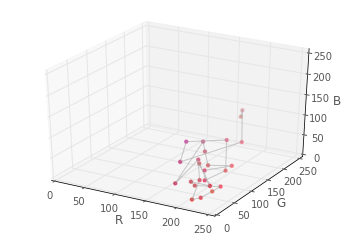

In [42]:
# MCMC sample path for single participant
pid = 58
# pid=275
print Participants.query(pid).target_color
qset = Questions.query('participant_id==@pid')
colorchoices = qset.set_index('question_number').selected_color
samples = colorchoices[colorchoices != colorchoices.shift()]
samples = np.asarray(samples.apply(RGBstring_to_tuple).tolist())
R,G,B = samples.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d',axisbg='w')
ax.set_xlim(0,255);ax.set_ylim(0,255);ax.set_zlim(0,255)
ax.set_xlabel('R');ax.set_ylabel('G');ax.set_zlabel('B')

ax.plot(xs=R,ys=G,zs=B,c='#999999',alpha=.5)
ax.scatter(xs=R,ys=G,zs=B,c=samples.astype(float)/256, alpha=.7);

# plt.savefig('subject_path_crimson.png')


In [37]:
# function that returns False if participant didn't complete task or answered >95% L or R
def valid_response(pid):
    if not Participants.query(pid).completed: return False
    qset = Questions.query('participant_id==@pid')
    if len(qset)==0: return False
    percent_left = sum(qset.selected_color == qset.color_left)/float(len(qset))
    if percent_left<.05 or percent_left > .95:
        return False
    else: return True

valid_pids = filter(valid_response, Participants.index.values)
len(valid_pids)

208

In [38]:
# Finding valid MCMC samples

# function that returns False if participant didn't complete task or answered >95% L or R
def valid_response(pid):
    if not Participants.query(pid).completed: return False
    qset = Questions.query('participant_id==@pid')
    if len(qset)==0: return False
    percent_left = sum(qset.selected_color == qset.color_left)/float(len(qset))
    if percent_left<.05 or percent_left > .95:
        return False
    else: return True

valid_pids = filter(valid_response, Participants.index.values)

# get rows of question info corresponding to MCMC samples (proposal accepted)
MCMC_rows = (Questions
     .query('participant_id in @valid_pids')
     .groupby(['participant_id'])
     .apply(lambda x: x.sort('question_number'))
     .assign(prev_color=lambda x: x.selected_color.shift())
     .assign(mcmc_sample=lambda x: x.selected_color!=x.prev_color)
     .query('mcmc_sample')
     .reset_index(0,drop=True)
)

# add extra cols for easier access of numeric color values

def RGBstring_to_tuple(rgb_str):
    return tuple([int(c) for c in rgb_str.strip('rgb()').split(',')])

MCMC_rows['color_tuple'] = MCMC_rows.selected_color.apply(RGBstring_to_tuple)
MCMC_rows['R_val'] = MCMC_rows.color_tuple.apply(lambda x:x[0])
MCMC_rows['G_val'] = MCMC_rows.color_tuple.apply(lambda x:x[1])
MCMC_rows['B_val'] = MCMC_rows.color_tuple.apply(lambda x:x[2])

# add participant info (target_color column) to df
MCMC_rows = pandas.merge(MCMC_rows,Participants,right_index=True,left_on='participant_id')

# function to return mcmc samples for a specified color
def get_MCMC_samples(targetcolor,qmin=0):
    MCMC_rows_filtered = (MCMC_rows
                 .query('question_number>=@qmin')
                 .query('target_color==@targetcolor')
                 )
    return np.asarray(MCMC_rows_filtered.selected_color.apply(RGBstring_to_tuple).tolist())


In [51]:
# count participants per color
MCMC_rows.groupby('target_color').participant_id.apply(lambda x: len(x.unique()))

target_color
blue        16
crimson     40
purple      55
sky blue    51
violet      46
Name: participant_id, dtype: int64

In [50]:
# Statistics on pooled sample distribution

qmin = 30 # only collect samples after 30th proposal
# pooled mean
mu = (MCMC_rows
     .query('question_number>=@qmin')
    .groupby('target_color')
    [['R_val','G_val','B_val']]
    .apply(np.mean)
    )
print "mean"
mu

# pooled mean
sigma = (MCMC_rows
     .query('question_number>=@qmin')
    .groupby('target_color')
    [['R_val','G_val','B_val']]
    .apply(np.std)
    )
print "st dev"
print sigma

mean
st dev
                  R_val      G_val      B_val
target_color                                 
blue          29.021647  51.276010  40.827448
crimson       64.760899  72.627001  65.746286
purple        57.045094  50.541749  51.626228
sky blue      64.148226  68.709588  57.491775
violet        67.052577  57.965486  60.727256


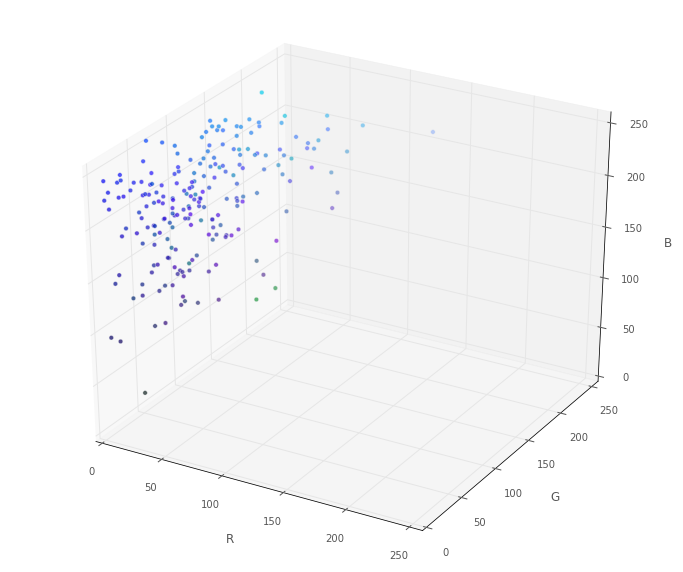

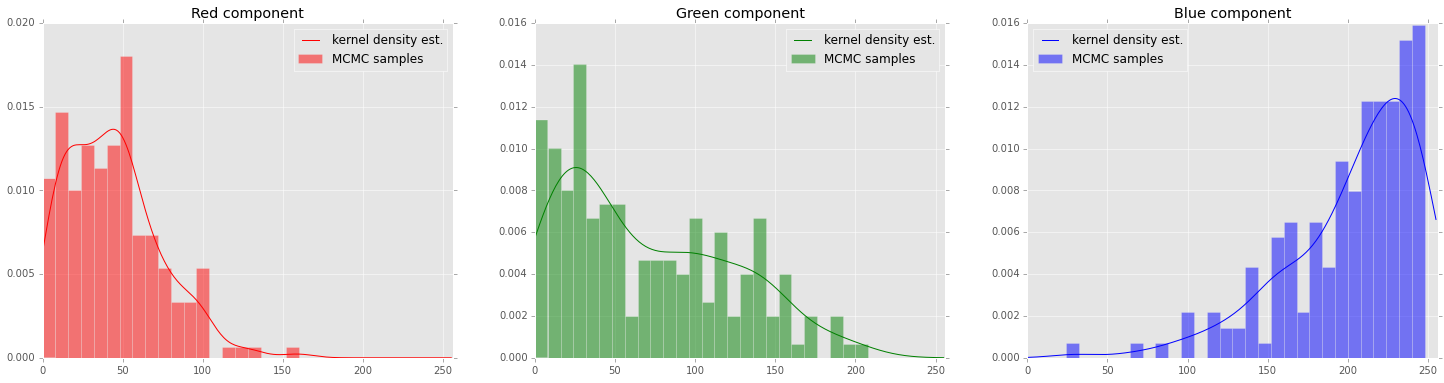

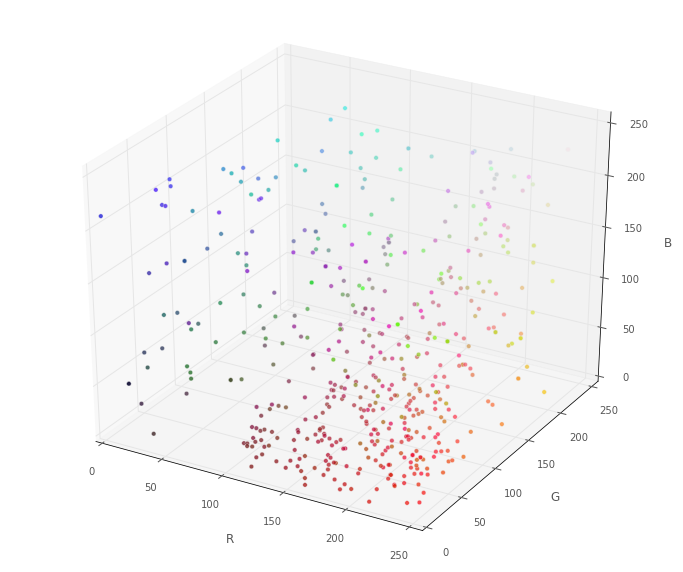

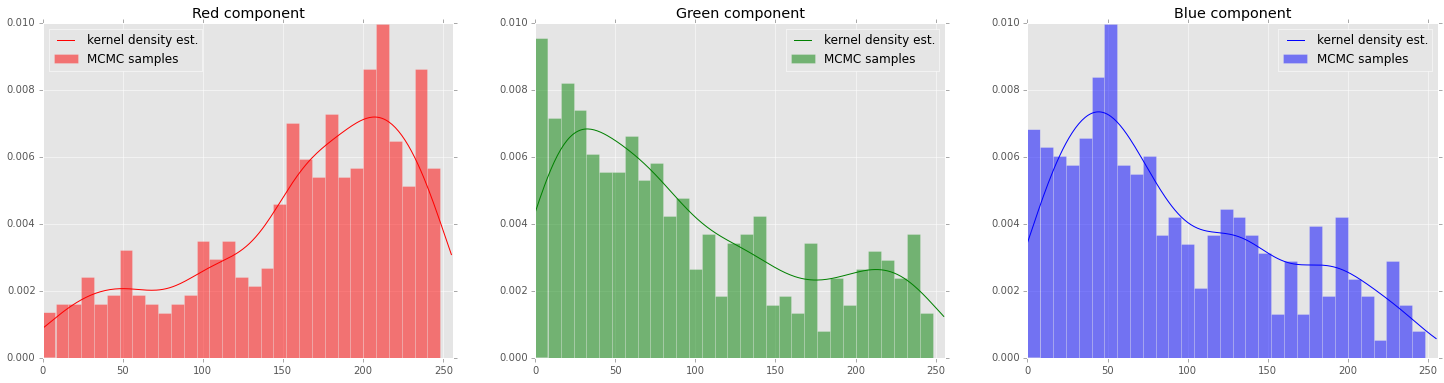

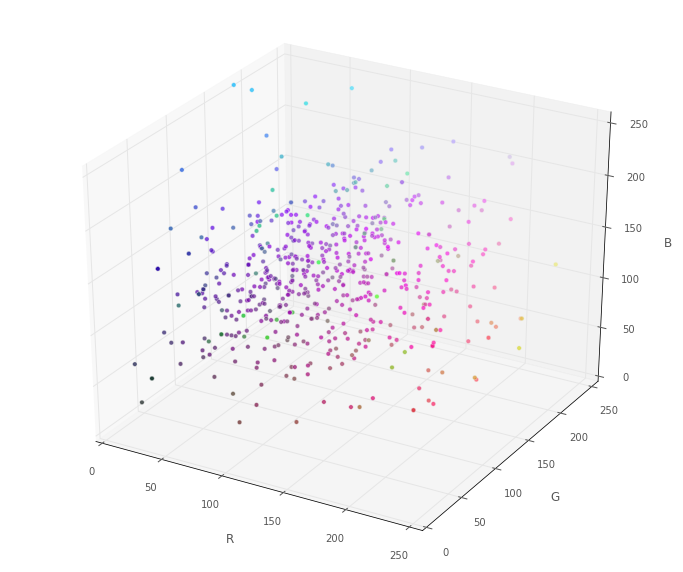

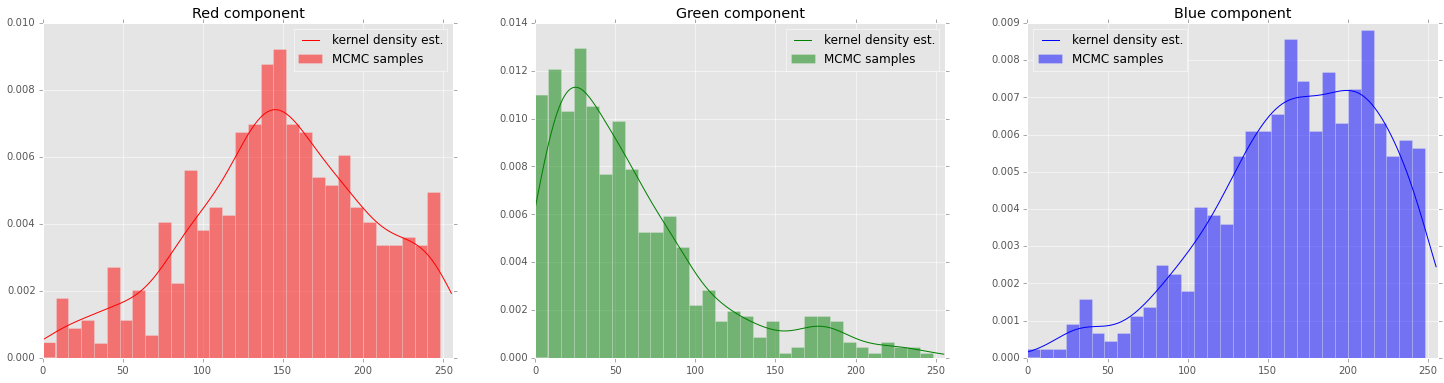

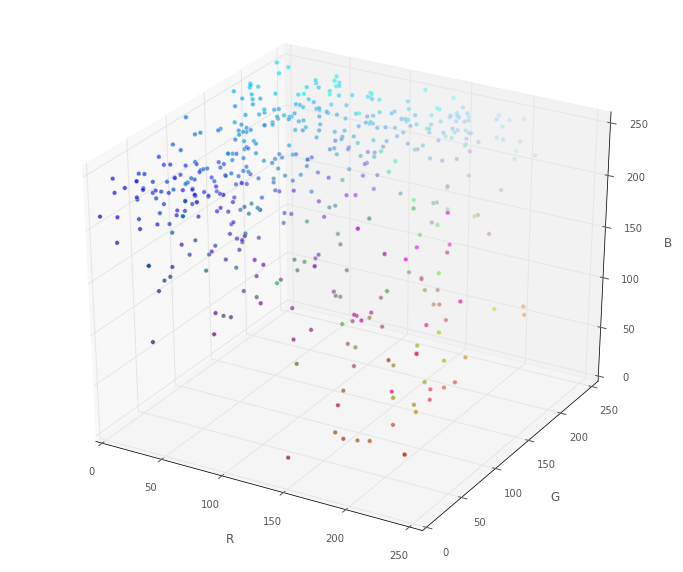

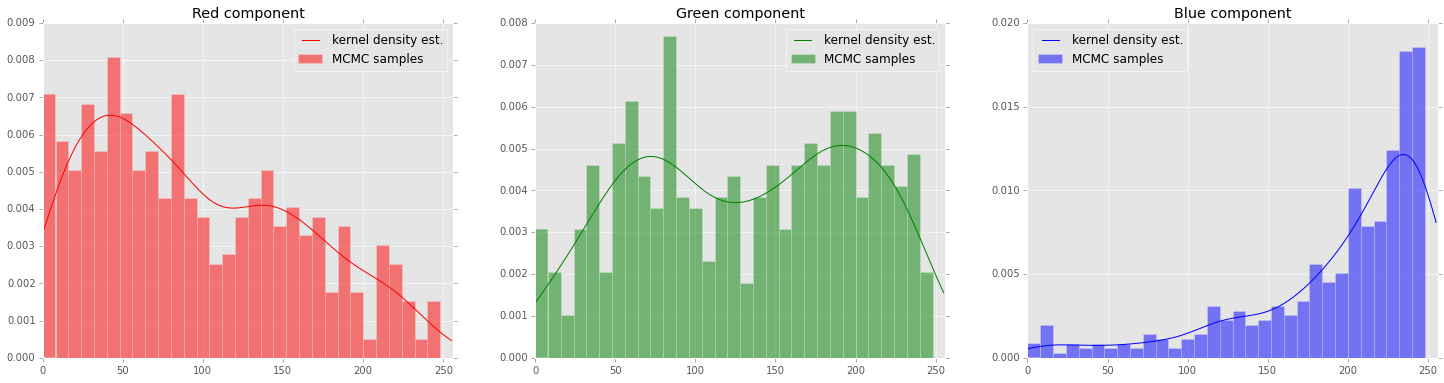

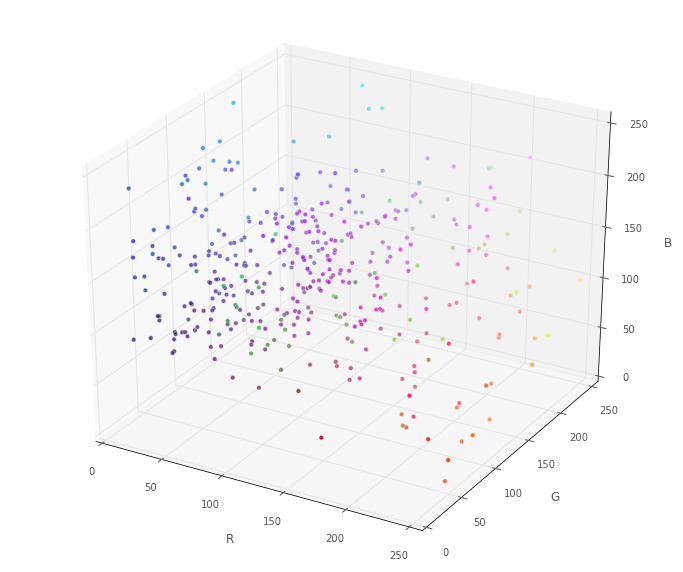

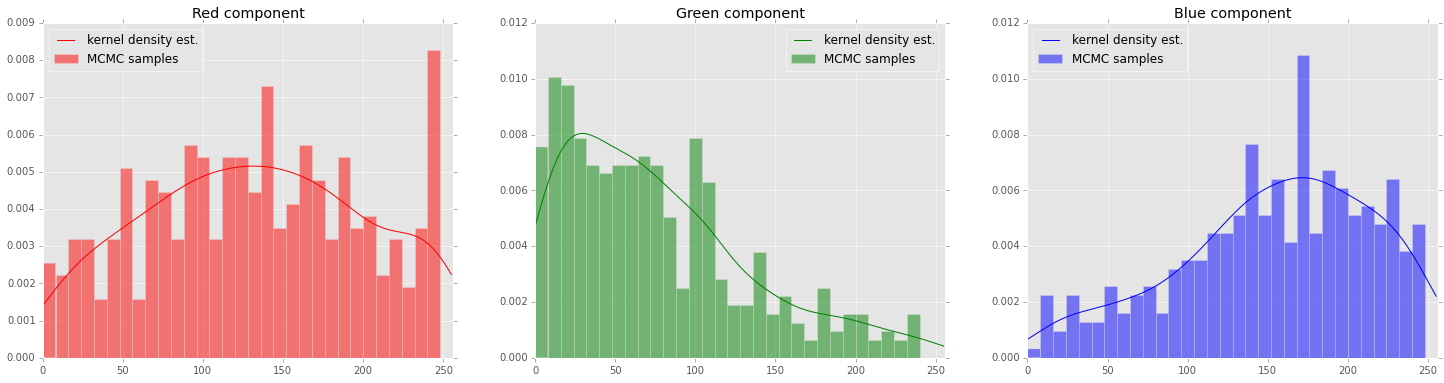

In [48]:
# Generate scatterplots in 3D color space and component histograms

target_colors = ['blue','crimson','purple','sky blue','violet']

RGBname = ['Red','Green','Blue']
plotnum = 1
for target_color in target_colors:
    MCMC_color = get_MCMC_samples(target_color,30)
    R,G,B = MCMC_color.T
    C = MCMC_color.astype(float)/256

    fig = plt.figure(plotnum,figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d',axisbg='w')
    ax.set_xlim(0,255);ax.set_ylim(0,255);ax.set_zlim(0,255)
    ax.set_xlabel('R');ax.set_ylabel('G');ax.set_zlabel('B')

    # ax.plot(xs=R,ys=G,zs=B,c='#999999',alpha=.5)
    ax.scatter(xs=R,ys=G,zs=B,c=C, alpha=.7)
    plt.savefig('mturk-3d {0}'.format(target_color))
    plotnum += 1
    
    # plot projections
    
    fig = plt.figure(plotnum,figsize=(25,6))
    for dim,RGBcode in enumerate(['r','g','b']):
        data = [R,G,B]

        # projection of mcmc samples
        projection = data[dim][20:]
        
        ax = fig.add_subplot(1,3,dim+1)
        ax.set_xlim(0,256)

        # kernel density estimate
        kernel = gaussian_kde(projection)
        normfactor = kernel.integrate_box_1d(0,256)
        kernel = kernel(range(256))/normfactor
        ax.plot(range(256),kernel,'{0}-'.format(RGBcode),label='kernel density est.')

        # histogram, bin width=32
        plt.hist(projection,bins=range(0,256,8),
                 normed=True,
                 label='MCMC samples',alpha=0.5,
                 color=RGBcode
                )

        # legend
        ax.legend(loc=0);
        plt.title('{0} component'.format(RGBname[dim]))
        
    plt.savefig('mturk-projection {0}'.format(target_color))
    plotnum += 1
